# Predictive Maintenance of a Water Pump

**Aim:** Given the sensor data, predict water pump failure in advance to guide timely maintenance scheduling. 

**Methodology:** Use an LSTM neural network (a type of RNN) to predict when a failure might happen based on time series data.

**Dataset:** [pump_sensor_data](https://www.kaggle.com/datasets/nphantawee/pump-sensor-data/metadata)

### Setup
Import the necessary libraries.

In [93]:
import pandas as pd
import numpy as np
import matplotlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from tensorflow.keras import models
from sklearn.preprocessing import OneHotEncoder
from platform import python_version
from sklearn.preprocessing import MinMaxScaler

In [94]:
print('Python version: {}'.format(python_version()))
print('Pandas version: {}'.format(pd.__version__))
print('Seaborn version: {}'.format(sns.__version__))
print('Sklearn version: {}'.format(sklearn.__version__))
print('Numpy version: {}'.format(np.__version__))
print('Matplotlib version: {}'.format(matplotlib.__version__))
print('Tensorflow version: {}'.format(tf.__version__))

Python version: 3.8.12
Pandas version: 1.3.4
Seaborn version: 0.11.2
Sklearn version: 1.0.2
Numpy version: 1.19.5
Matplotlib version: 3.4.2
Tensorflow version: 2.6.0


### Get Data

Load the pump sensor data.

In [95]:
# parse timestamp column as datetime object upon reading the data
df_raw_data = pd.read_csv('data/sensor.csv', parse_dates=['timestamp'], index_col=0)

In [96]:
# specify the target feature as a categorical data type
df_raw_data['machine_status'] = pd.Categorical(df_raw_data['machine_status'], 
                                                categories=['BROKEN', 'NORMAL', 'RECOVERING'],
                                                ordered=True)

## Data Exploration

In [97]:
# initial look at the features
df_raw_data.head()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [98]:
# determine the size of the dataset
print('The dataset has the following shape: {}'.format(df_raw_data.shape))

The dataset has the following shape: (220320, 54)


To sum up, there are 52 sensors with a measurement made every minute for 220320 minutes (153 days). The `machine_status` column is the target feature that will be used to predict maintenance and will be explored next. 

In [99]:
# investigate the number of features for each target feature
df_raw_data.groupby('machine_status')['machine_status'].count()

machine_status
BROKEN             7
NORMAL        205836
RECOVERING     14477
Name: machine_status, dtype: int64

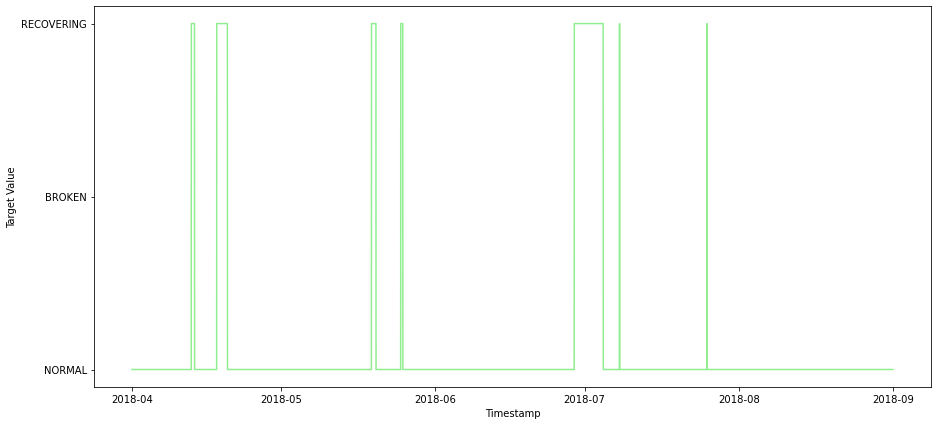

In [100]:
# create a figure
fig, ax = plt.subplots(figsize=(15, 7))

# add data to axis
ax.plot(df_raw_data['timestamp'],
        df_raw_data['machine_status'],
        color='lightgreen')

# set title and labels
ax.set(ylabel = 'Target Value',
    xlabel = 'Timestamp')

plt.show()

Among the ~220k instances only 7 indicate when the machine has been broken. With only seven instances it is impossible to train an ML model in a meaningful way. However, from the plot above, it is evident that 'BROKEN' events are always clustered together with the 'RECOVERING' events that could be used as a proxy to predict when a machine has been broken. 

Despite there being substantially more 'RECOVERING' events compared to 'BROKEN' events, they still constitute only ~6.5% of total instances. The imbalance in the dataset will be an important fact to consider when evaluating the performance of the model later on.

## Data Cleaning 

At this stage, the completeness of the dataset is considered and the following questions asked:
- How many NaN values are there?
- Are NaN values clustered around certain features (columns) or instances (rows)?
- Can the missing values be filled in or have to be removed altogether?

In [101]:
# check if there are Null values in the dataset
print('Number of NaN values in the dataset: {}'.format(df_raw_data.isnull().sum().sum()))

Number of NaN values in the dataset: 344574


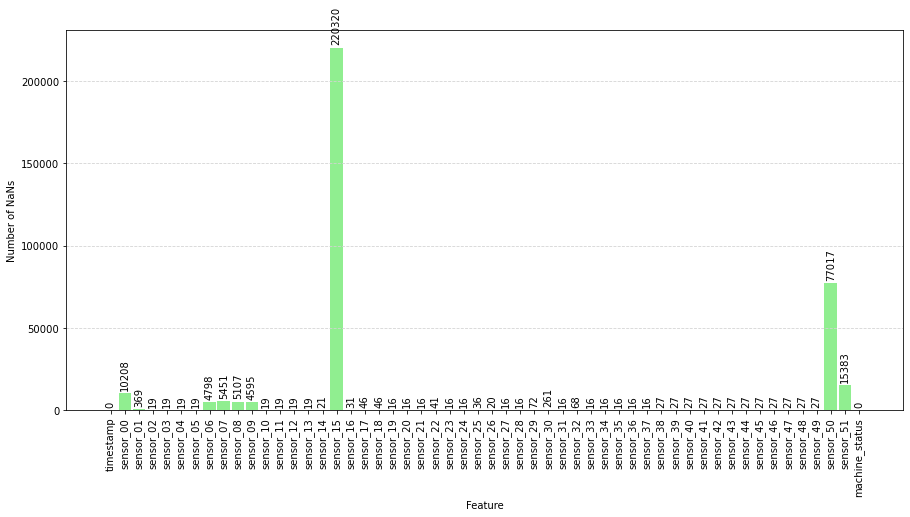

In [102]:
# find the number of NaNs for each feature 
count_nans = df_raw_data.isnull().sum().to_frame('count_nans')

# create a figure
fig, ax = plt.subplots(figsize=(15, 7))

# add data to axis
bar = ax.bar(count_nans.index,
        count_nans['count_nans'],
        width=0.9,
        color='lightgreen')

# set title and labels
ax.set(ylabel = 'Number of NaNs',
    xlabel = 'Feature')

# rotate the x axis labels for better readability 
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

ax.bar_label(bar, padding=3, rotation=90)

plt.grid(color='lightgray', linestyle='--', axis='y')
plt.show()

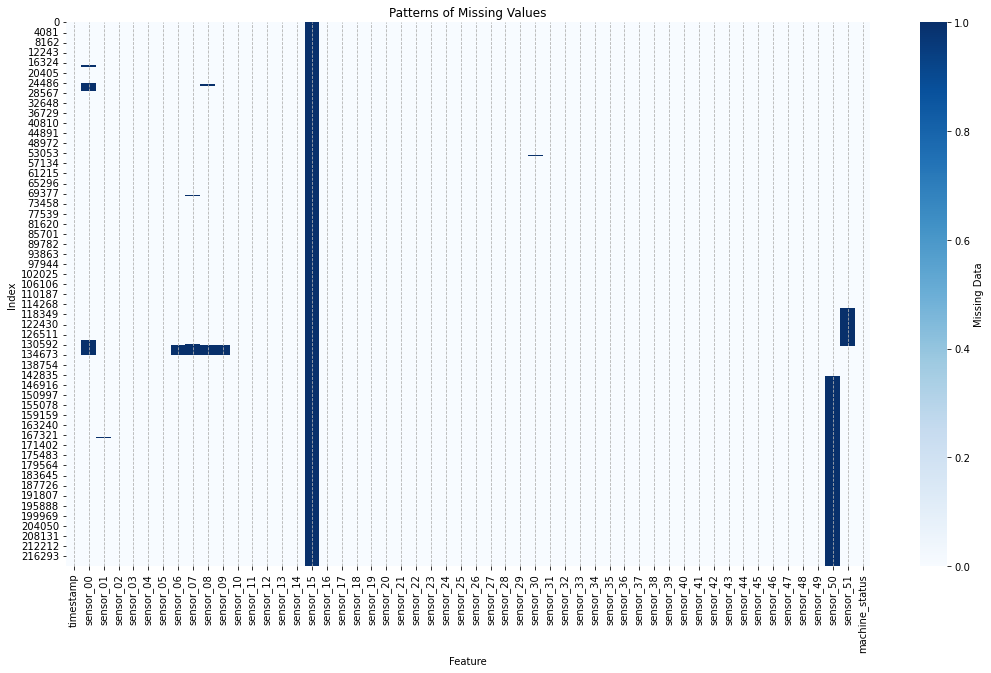

In [103]:
import seaborn as sns
# create a figure
fig, ax = plt.subplots(figsize=(18, 10))
# create a heatmap from missing values
ax  = sns.heatmap(df_raw_data.isnull(), cmap='Blues', cbar_kws={'label': 'Missing Data'})
# set title and labels
ax.set(ylabel = 'Index',
    xlabel = 'Feature')

ax.grid(axis='x', linestyle='--') # vertical grid lines
plt.title('Patterns of Missing Values')

plt.savefig('nan_matrix.png')

plt.show()

From bar chart and heatmap above it is evident that `sensor_15` is missing all values and will need to be removed. Other sensors with a large number of missing values include `sensor_00`, `sensor_06` - `sensor_09`, `sensor_50` and `sensor_51` and need to be investigated in more detail. 

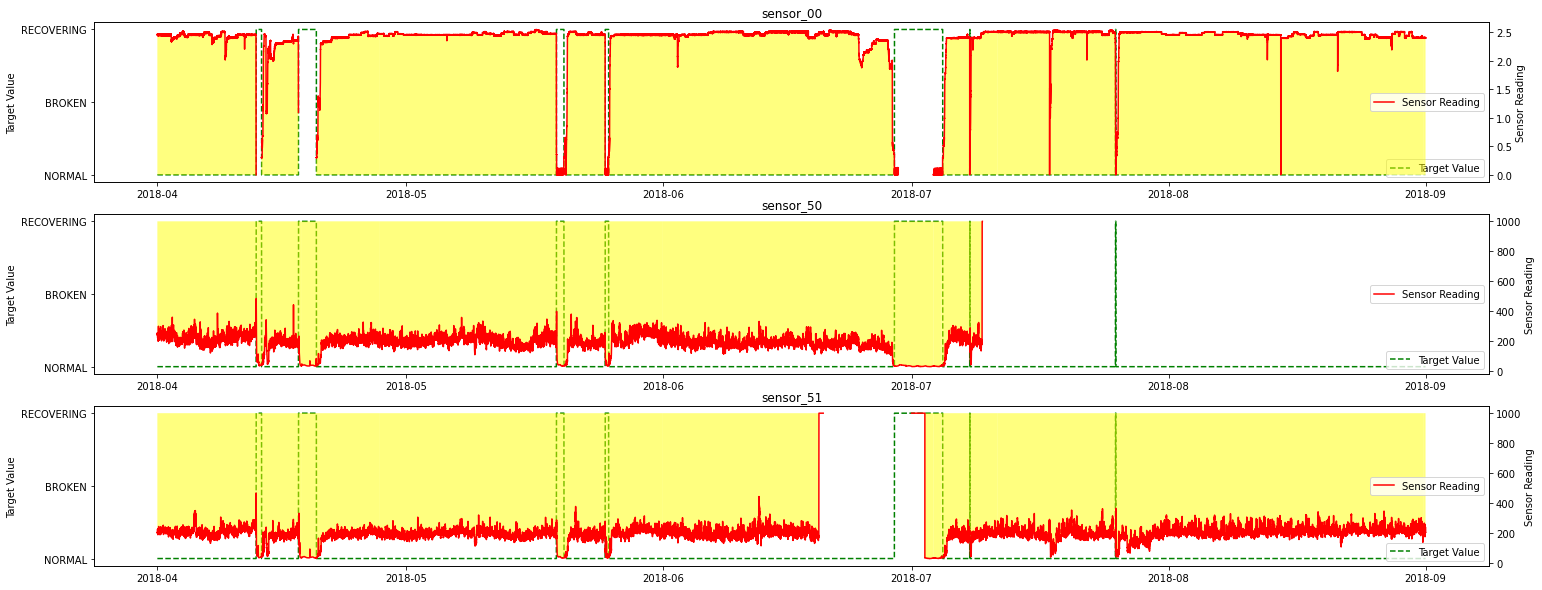

In [104]:
# create a figure
fig, ax = plt.subplots(3,1,figsize=(25, 10))
# sensors to be plotted
axes = ['sensor_00', 'sensor_50', 'sensor_51']

for i, a in enumerate(axes):

        # add data to axis
        ax[i].plot(df_raw_data['timestamp'],
                df_raw_data['machine_status'],
                color='green',
                linestyle='--')

        # create the second y axis
        ax02 = ax[i].twinx()
        # add data to the second axis
        ax02.plot(df_raw_data['timestamp'],
                df_raw_data[a],
                color='red')
        ax[i].set(ylabel= 'Target Value', title=a)
        ax02.set(ylabel = 'Sensor Reading')

        # Code by Mr.T from StackOverflow: https://stackoverflow.com/questions/66483363/highlight-data-gaps-nan-in-matplotlib-scatter-plot
        # fill in the area above/below the graph to highlight the gaps in the data
        if i == 0:
                ax02.fill_between(df_raw_data['timestamp'], df_raw_data[a], df_raw_data[a].min(), where=np.isfinite(df_raw_data[a]), facecolor="yellow", alpha=0.5)
        else:
                 ax02.fill_between(df_raw_data['timestamp'], df_raw_data[a], df_raw_data[a].max(), where=np.isfinite(df_raw_data[a]), facecolor="yellow", alpha=0.5)

        ax02.legend(['Sensor Reading'], loc='center right')
        ax[i].legend(['Target Value'], loc='lower right')

plt.show()

From the graphs above it is evident that `sensor_50` stop producing any signal two thirds through the reading. Similarly, `sensor_51` gives out for a chunk of the time in the middle of the reading. As Jan Werth point out in [his article](https://towardsdatascience.com/lstm-for-predictive-maintenance-on-pump-sensor-data-b43486eb3210) the readings for `sensor_50` and `sensor_51` are remarkably similar and could be combined to reconstruct one of the readings.

I've decided to use the data from `sensor_51` to construct `sensor_50` (the more straight forward option). In addition, both sensors appear to give a very high reading just before/after malfunctioning, therefore I'll assume this the result of the sensor failure and not the actual state of the machine. In the process of merging the data from `sensor_50` and `sensor_51` these atypically high readings will be removed.

Similar to `sensor_51`, `sesnor_00` and `sesnor_06` - `sesnor_09` malfunction for extended chunks of time. To further evaluate, how to deal with NaNs in `sesnor_00` and others, the variance for data readings are plotted. The reasoning being that we want to keep sensors with a high variability in their readings that might point to the malfunction.

/var/folders/n8/lyd38hsj3kl16nsbtrppwjbw0000gn/T/ipykernel_75796/2432662497.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_var = df_raw_data.var().to_frame('var')


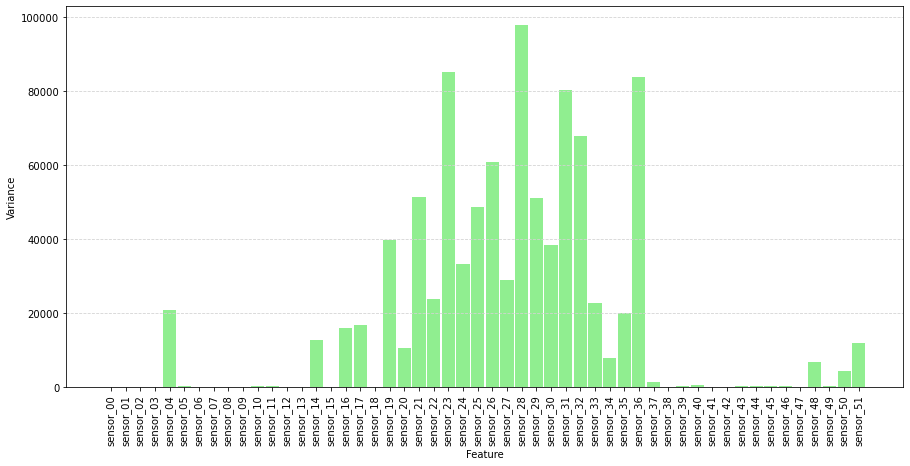

In [105]:
df_var = df_raw_data.var().to_frame('var')

# create a figure
fig, ax = plt.subplots(figsize=(15, 7))

# add data to axis
bar = ax.bar(df_var.index,
        df_var['var'],
        width=0.9,
        color='lightgreen')

# set title and labels
ax.set(ylabel = 'Variance',
    xlabel = 'Feature')

# rotate the x axis labels for better readability 
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

# ax.bar_label(bar, padding=3, rotation=90)

plt.grid(color='lightgray', linestyle='--', axis='y')
plt.show()

Based on the sensor variances the following features can be removed:
* from `sesnor_00` to `sensor_03` (inclusive)
* from `sesnor_05` to `sensor_13` (inclusive)
* `sensor_15`
* `sensor_18`
* from `sesnor_38` to `sensor_39` (inclusive)
* from `sesnor_41` to `sensor_47` (inclusive)
* `sensor_49`

Removing some of these sensors also solves the issue of extended gaps of NaN values. 

The remaining NaN values will be filled using `fillna()` function and `ffill` method with a limit of 30 (only fill up to 30 consecutive NaN values in the same column). The limit value is an arbitrary choice.

## Feature Engineering

Following the insights in the previous section, the necessary changes are made to the dataset. The changes are summarised below:
* Drop `sensor_15`
* Combine data from `sensor_50` and `sensor_51`
* Drop sensors with little variance (summarised above)
* Fill NaN values

In addition, data are split into training, testing and validation sets and normalised following the steps in this [Tensorflow article.](https://www.tensorflow.org/tutorials/structured_data/time_series)

In [106]:
# drop empty features/ features with little variance
df_eng = df_raw_data.drop(columns=['sensor_00',  'sensor_06', 'sensor_07', 
                                    'sensor_08', 'sensor_09',  'sensor_15' ]).copy()

In [107]:
# combine data from sensor_50 and sensor_51 into a new feature
df_eng['sensor_50'] = df_eng.apply(lambda x: x['sensor_50'] if pd.isna(x['sensor_50']) == False else x['sensor_51'], axis=1)

In [108]:
# drop data for sensor_50 and sensor_51
df_eng = df_eng.drop(columns=['sensor_51'])

In [109]:
# fill NaN values 
df_eng = df_eng.fillna(method='ffill', limit=30)

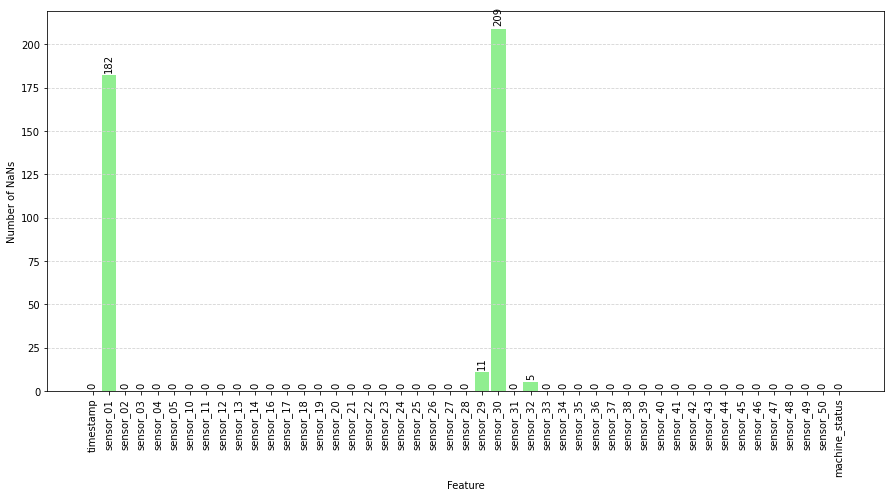

In [110]:
# plot the remaining NaN value to identify to identify how to deal with them
# find the number of NaNs for each feature 
count_nans_eng = df_eng.isnull().sum().to_frame('count_nans')

# create a figure
fig, ax = plt.subplots(figsize=(15, 7))

# add data to axis
bar = ax.bar(count_nans_eng.index,
        count_nans_eng['count_nans'],
        width=0.9,
        color='lightgreen')

# set title and labels
ax.set(ylabel = 'Number of NaNs',
    xlabel = 'Feature')

# rotate the x axis labels for better readability 
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

ax.bar_label(bar, padding=3, rotation=90)

plt.grid(color='lightgray', linestyle='--', axis='y')

plt.show()

After dropping the features with excessive gaps in data and forward-filling the rest, some NaNs still remain. These values constitute less than 0.2% of the total dataset therefore are simply dropped.

In [111]:
# drop the remaining NaN values
df_eng = df_eng.dropna()

## Data Prep for the LSTM

Time series forecasting problems require the re-formatting of data into input and output pairs. The steps outlined in Jason Brownlee's [article](https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/) are followed to convert the time series data into a supervised learning problem. 

In [112]:
# code reference: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('sensor%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('sensor%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('sensor%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [113]:
# generate the shifted dataset 
future = 10
data_shift = series_to_supervised(df_eng, n_in=future, n_out=1)

In [114]:
data_shift.head()

,sensor1(t-10),sensor2(t-10),sensor3(t-10),sensor4(t-10),sensor5(t-10),sensor6(t-10),sensor7(t-10),sensor8(t-10),sensor9(t-10),sensor10(t-10),...,sensor38(t),sensor39(t),sensor40(t),sensor41(t),sensor42(t),sensor43(t),sensor44(t),sensor45(t),sensor46(t),sensor47(t)
10,2018-04-01 00:00:00,47.09201,53.2118,46.310760,634.3750,76.45975,37.22740,47.52422,31.11716,1.681353,...,31.510416,41.40625,39.351850,54.97685,50.92593,39.35185,190.9722,71.18056,250.8681,NORMAL
11,2018-04-01 00:01:00,47.09201,53.2118,46.310760,634.3750,76.45975,37.22740,47.52422,31.11716,1.681353,...,31.510416,41.66666,39.351852,53.81944,51.21528,39.06250,193.5764,72.33796,253.1829,NORMAL
12,2018-04-01 00:02:00,47.35243,53.2118,46.397570,638.8889,73.54598,37.86777,48.17723,32.08894,1.708474,...,31.510416,42.70833,39.351850,53.24074,50.92593,39.06250,195.6019,72.33796,253.1829,NORMAL
13,2018-04-01 00:03:00,47.09201,53.1684,46.397568,628.1250,76.98898,38.57977,48.65607,31.67221,1.579427,...,31.510416,42.70833,40.509260,53.81944,50.63657,39.06250,196.4699,72.91666,252.8935,NORMAL
14,2018-04-01 00:04:00,47.13541,53.2118,46.397568,636.4583,76.58897,39.48939,49.06298,31.95202,1.683831,...,31.510416,42.18750,41.666670,53.53009,50.34722,39.06250,205.4398,72.91666,252.0255,NORMAL


The `series_to_supervised()` function return the original and shifted sensor data - a column for each shift. Now all the unnecessary columns need to be removed. These include all `sensor1(t-n)` and `sensor1(t)` columns (i.e., the timestamps) and all `sensor28(t-n)` (i.e., the shifted target values) and for every sensor `(t-n)` values where `n != future` (i.e., the desired time step).

In [115]:
# code reference: https://towardsdatascience.com/lstm-for-predictive-maintenance-on-pump-sensor-data-b43486eb3210
# a function to remove unnecessary columns resulting from the shift 

def remove_cols(data_shift, df_eng, future):
    to_remove_list_1 =['sensor'+str(n)+'(t)' for n in range(1,len(df_eng.columns)+1)] #now remove all non shifted elements again. so we retrieve elements and shifted target
    to_remove_list_2 =['sensor'+str(n)+'(t-'+ str(i)+')' for n in range(1,len(df_eng.columns)+1) for i in range(1,future)] #now remove all shifted elements where n!=future.
    to_remove_list=to_remove_list_1+to_remove_list_2
    data_y=data_shift.iloc[:,-1] #Get the target data out before removing unwanted data
  
    data_x=data_shift.drop(columns = to_remove_list, axis=1) #remove sensors(t)
    data_x.drop(data_x.columns[-1], axis=1, inplace=True)# remove target(t-n)
    data_x.drop(data_x.columns[0], axis=1, inplace=True)# remove timestamps(t-n)

    return data_y, data_x
    

In [116]:
data_y, data_x = remove_cols(data_shift=data_shift,df_eng=df_eng, future=future)

Following data prep for LSTM, data are split into training, testing and validation sets. Contrary to most datasets, this datasets is not randomly shuffled prior splitting to maintain the contextual information of time series data.

During the data exploration phase it was noted that the range of sensors vary significantly (e.g., compare reading from `sensor_00` and `sensor_50`), therefore data are normalised to speed up the training time (large input values can saturate the activation function that can affect the gradient). In this case the MinMaxScaler is used to translate values to a range between 0 and 1 using the following formulas:

    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    X_scaled = X_std * (max - min) + min

In [117]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))

data_x = scaler.fit_transform(data_x)

Finally, the target values are encoded, dataset is split for training, testing and validation and data are reshaped to fit the LSTM model. Target features are encoded using LabelEncoding that assigns an integer value to each categorical value. This encoding is chosen for simplicity but has its drawbacks - the algorithm can misinterpret the values as having implied relationship/ hierarchy. In the future, one hot encoding could be used instead to address the limitations of label encoding.

After target encoding, data are split into training, testing and validation datasets. The training dataset will use the majority of data (70%), validation dataset is used for unbiased evaluating while the model is being tuned (10% of data) and the test set will be used to evaluate the final model (20%).

Finally, the dataset need to be reshaped into a (instances, timesteps, features) format for the LSTM model.

In [118]:
# Code reference: https://towardsdatascience.com/lstm-for-predictive-maintenance-on-pump-sensor-data-b43486eb3210
# encode y values
from sklearn.preprocessing import LabelEncoder

labelEn = LabelEncoder()
data_y = labelEn.fit_transform(data_y)


In [119]:
# a function for splitting x and y datasets into training, testing and validation sets
def split_data(data_x, data_y):
    d_x = np.array(data_x)
    d_y = np.array(data_y)
    
    # split data into train (70%), test(10%) and validation(20%) sets
    n = len(data_x)
    test_x = d_x[0:int(n*0.1)]
    val_x = d_x[int(n*0.1):int(n*0.3)]
    train_x = d_x[int(n*0.3)::]
    test_y = d_y[0:int(n*0.1)]
    val_y = d_y[int(n*0.1):int(n*0.3)]
    train_y = d_y[int(n*0.3)::]

    return train_x, test_x, val_x, train_y, test_y, val_y

train_x, test_x, val_x, train_y, test_y, val_y = split_data(data_x, data_y)

 

In [120]:
# one hot encoded values
train_y_cat, test_y_cat, val_y_cat = tf.keras.utils.to_categorical(train_y, 3), tf.keras.utils.to_categorical(test_y, 3), tf.keras.utils.to_categorical(val_y, 3)

In [121]:
# reshape for LSTM input 
timesteps=1
samples_T=int(np.floor(train_x.shape[0]/timesteps))
samples_V=int(np.floor(val_x.shape[0]/timesteps))
samples_Te=int(np.floor(test_x.shape[0]/timesteps))
    
train_x=train_x.reshape((samples_T,timesteps,train_x.shape[1]))   #samples, timesteps, sensors   
val_x=val_x.reshape((samples_V,timesteps,val_x.shape[1]))       
test_x=test_x.reshape((samples_Te,timesteps,test_x.shape[1])) 


In [122]:
train_x.dtype

dtype('float64')

## LSTM Model Setup

In [128]:
# Code reference: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
from keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# model = Sequential()
# model.add(LSTM(units=40, activation='relu', input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
# # model.add(LSTM(units=40, activation='relu'))
# model.add(Dense(units=3,  activation='softmax'))
# model.compile(loss='mse', optimizer='adam', metrics='accuracy')
# input layer must fit the input shape
inputs= tf.keras.Input(shape=(train_x.shape[1],train_x.shape[2]))
# connect input layer to LSTM layer with 20 units
x=LSTM(20,activation='relu', input_shape=(train_x.shape[1],train_x.shape[2]),return_sequences=True)(inputs)
x=LSTM(42,activation='relu')(x)
out_signal=Dense(1, name='signal_out')(x)
out_class=Dense(3,activation='softmax', name='class_out')(x)

model=tf.keras.Model(inputs=inputs, outputs=[out_signal,out_class])
    
model.compile(loss={'signal_out':'mean_squared_error',
                        'class_out' :'categorical_crossentropy'},
                         optimizer='adam',
                         metrics={'class_out':'acc'})

model.summary()
history = model.fit(train_x, [train_y,train_y_cat], epochs=50, validation_data=(val_x, [val_y,val_y_cat]), shuffle=False)
# plot_training(history,saving=True,name=('training'+ str(future_10)))  

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1, 45)]      0                                            
__________________________________________________________________________________________________
lstm_29 (LSTM)                  (None, 1, 20)        5280        input_5[0][0]                    
__________________________________________________________________________________________________
lstm_30 (LSTM)                  (None, 42)           10584       lstm_29[0][0]                    
__________________________________________________________________________________________________
signal_out (Dense)              (None, 1)            43          lstm_30[0][0]                    
____________________________________________________________________________________________

In [129]:
[yhat,yclass] = model.predict(test_x)

In [130]:
Yclass=[np.argmax(yclass[i],0) for i in range(len(yclass))] # get final class

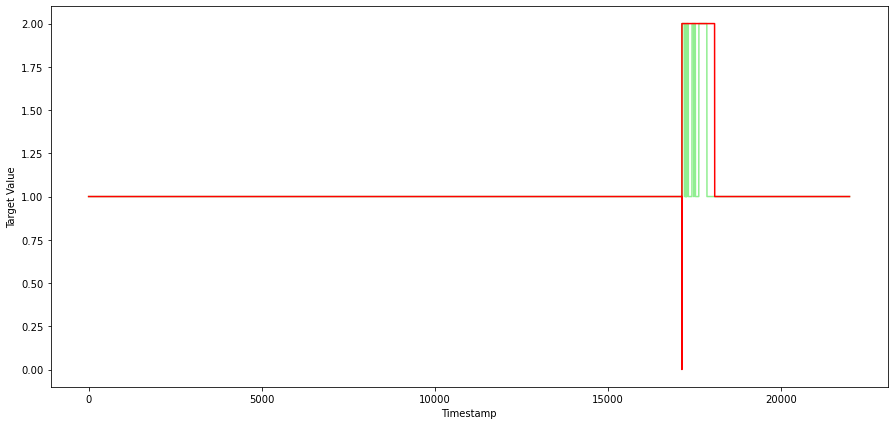

In [131]:
# create a figure
fig, ax = plt.subplots(figsize=(15, 7))

# add data to axis
ax.plot(Yclass,
        color='lightgreen')
ax.plot(test_y, color='red')

# set title and labels
ax.set(ylabel = 'Target Value',
    xlabel = 'Timestamp')

plt.show()

In [132]:
import sys
np.set_printoptions(threshold=sys.maxsize)
test_y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,